In [95]:
import glob
import pandas as pd
import numpy as np

import re
import string
import nltk

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stopwords_eng = stopwords.words("english")
from nltk.corpus import wordnet

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

from autocorrect import Speller
spell = Speller()


from tqdm import tqdm

import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
datasets = glob.glob('../dataset/*.csv')
dataframes = [pd.read_csv(file) for file in datasets]
df = pd.concat(dataframes, axis = 0, ignore_index=True)

In [4]:
df.head()

job id                           job_title           company_name  \
0  3856120323  Vice President of Customer Support     Motion Recruitment   
1  3852723097        Sr. Customer Success Manager         Social Benefit   
2  3855972061      Night Warehouse Order Selector  Direct Employers Jobs   
3  3856133377       Marketing/Social Media Intern                    FTC   
4  3856133739                     Product Manager                Oddball   

  company_location     posted_time  \
0      Atlanta, GA      1 hour ago   
1  Los Angeles, CA  28 minutes ago   
2  Kailua-Kona, HI     2 hours ago   
3     New York, NY      1 hour ago   
4    United States  50 minutes ago   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [5]:
df.columns

Index(['job id', 'job_title', 'company_name', 'company_location',
       'posted_time', 'description'],
      dtype='object')

In [6]:
df.shape

(19906, 6)

In [7]:
df.drop_duplicates(subset=['job id', 'description'], inplace=True)

In [8]:
df.shape

(8077, 6)

In [9]:
df.dtypes

job id              object
job_title           object
company_name        object
company_location    object
posted_time         object
description         object
dtype: object

In [10]:
def get_sent_count(desc): 
    if not isinstance(desc, str): 
        return 0
    return len(sent_tokenize(desc))

In [11]:
def get_word_count(desc): 
    if not isinstance(desc, str): 
        return 0
    return len(word_tokenize(desc))

In [12]:
df['sent_count'] = df.description.apply(get_sent_count)

In [13]:
df['word_count'] = df.description.apply(get_word_count)

In [14]:
df['sent_count'].describe()

count    8077.000000
mean       13.673394
std        14.067491
min         0.000000
25%         5.000000
50%         9.000000
75%        18.000000
max       141.000000
Name: sent_count, dtype: float64

In [15]:
df['word_count'].describe()

count    8077.000000
mean      570.658041
std       447.374383
min         0.000000
25%       272.000000
50%       459.000000
75%       718.000000
max      3534.000000
Name: word_count, dtype: float64

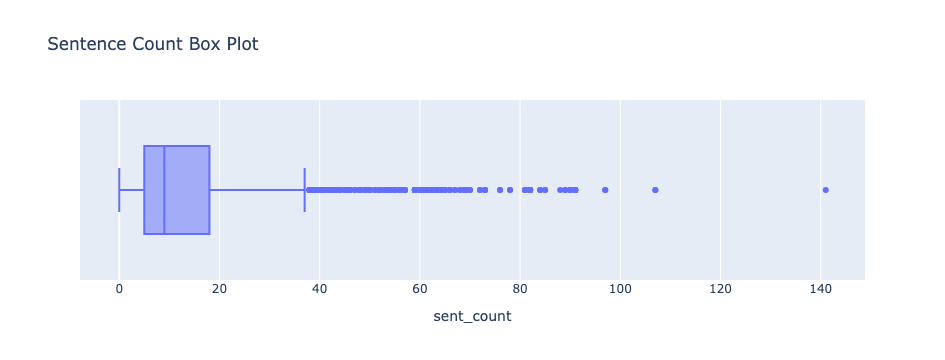

In [16]:
fig = px.box(df, x="sent_count", title="Sentence Count Box Plot")
fig.show()

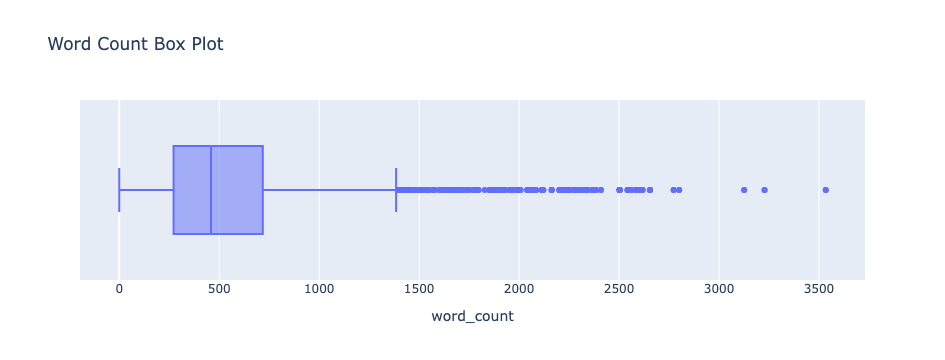

In [17]:
fig = px.box(df, x="word_count", title="Word Count Box Plot")
fig.show()

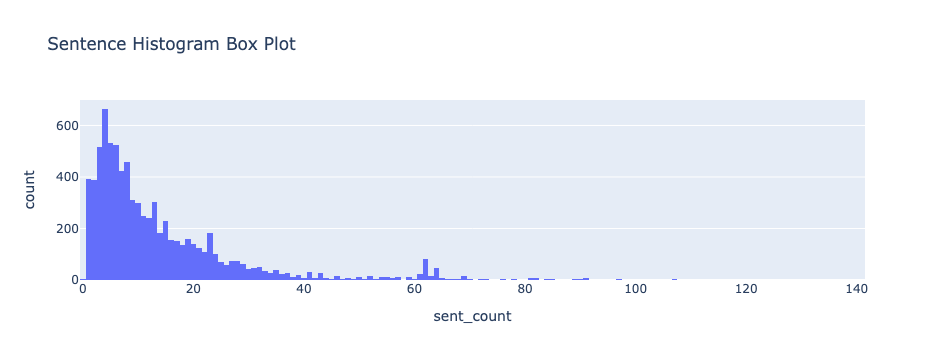

In [18]:
fig = px.histogram(df, x='sent_count',title="Sentence Histogram Box Plot")
fig.show()

In [19]:
df['sent_count'].skew().round(2)

2.39

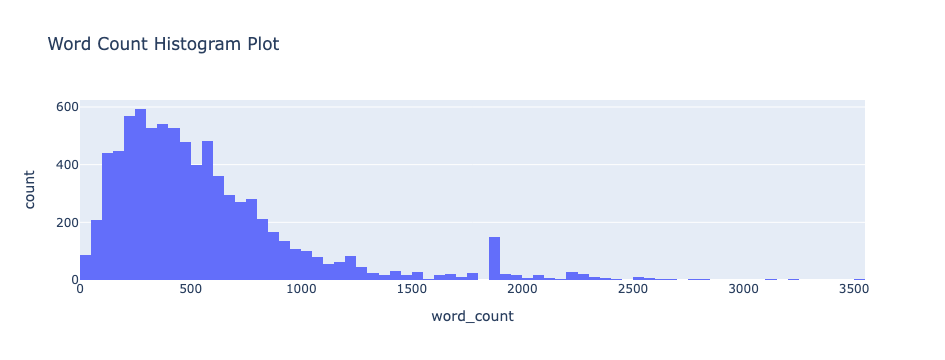

In [20]:
fig = px.histogram(df, x='word_count', title="Word Count Histogram Plot")
fig.show()

In [21]:
df['word_count'].skew().round(2)

1.97

In [22]:
def calculate_whiskers(colname): 
    q1 = df[colname].quantile(.25)
    q3 = df[colname].quantile(.75)
    iqr = q3 - q1
    w_multiplier = 1.5 * iqr
    lower_whisker = q1 - w_multiplier
    upper_whisker = q3 + w_multiplier
    return upper_whisker, lower_whisker

In [23]:
# lets do 2 techniques, Capping, Log
def trimming_outlier(tb_df, colname):
    print('Number of records in DataFrame', tb_df.shape)
    uw, lw = calculate_whiskers(colname)
    index = tb_df[(tb_df[colname] > lw) & (tb_df[colname] < uw)]
    print('Number of records in DataFrame after removing outlier', index.shape)
    
    return index
    

In [24]:
t_df = trimming_outlier(df, 'sent_count')

Number of records in DataFrame (8077, 8)
Number of records in DataFrame after removing outlier (7596, 8)


In [25]:
t_df = trimming_outlier(t_df, 'word_count')

Number of records in DataFrame (7596, 8)
Number of records in DataFrame after removing outlier (7468, 8)


In [26]:
t_df['sent_count'].skew().round(2)

1.06

In [27]:
t_df['word_count'].skew().round(2)

0.72

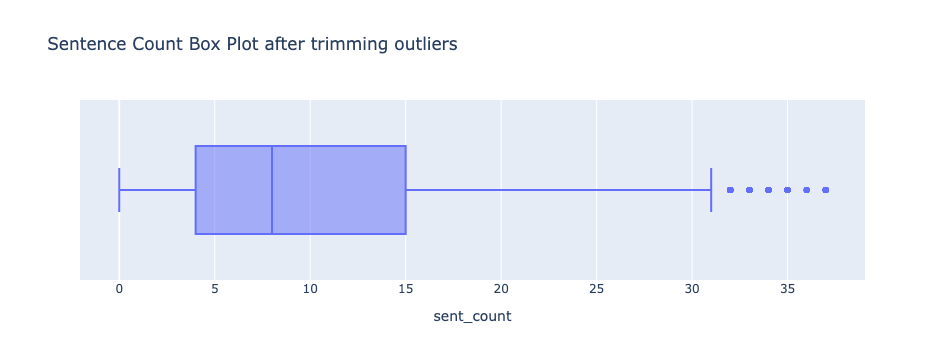

In [28]:
fig = px.box(t_df, x="sent_count", title="Sentence Count Box Plot after trimming outliers")
fig.show()

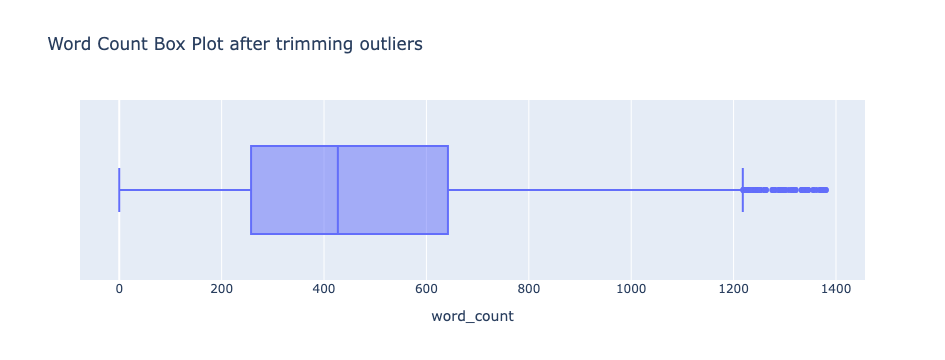

In [29]:
fig = px.box(t_df, x="word_count", title="Word Count Box Plot after trimming outliers")
fig.show()

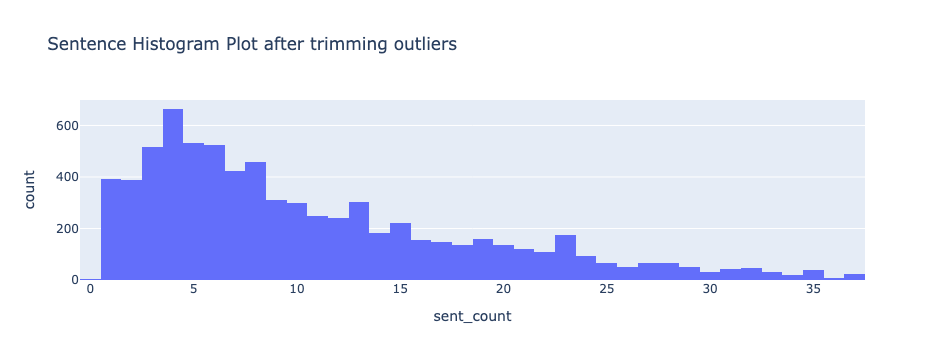

In [30]:
fig = px.histogram(t_df, x='sent_count',title="Sentence Histogram Plot after trimming outliers")
fig.show()

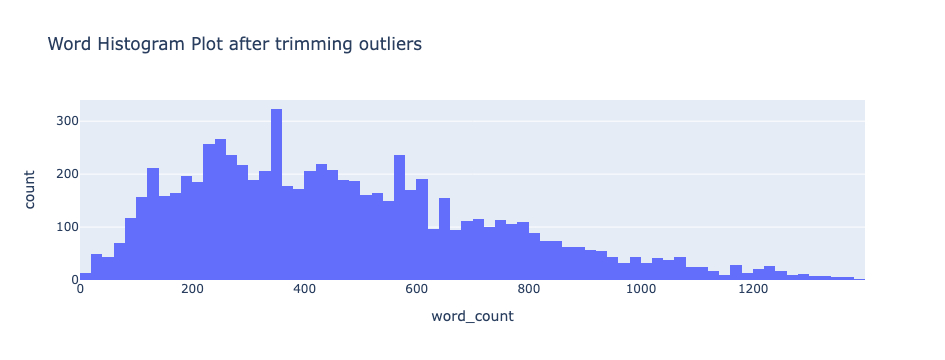

In [31]:
fig = px.histogram(t_df, x='word_count',title="Word Histogram Plot after trimming outliers")
fig.show()

In [32]:
def log_transformation(colname): 
    df[f'{colname}_logscale'] = df[colname].map(lambda x: np.log(x) if x > 0 else 0)

In [33]:
l_df = log_transformation('sent_count')

In [34]:
l_df = log_transformation('word_count')

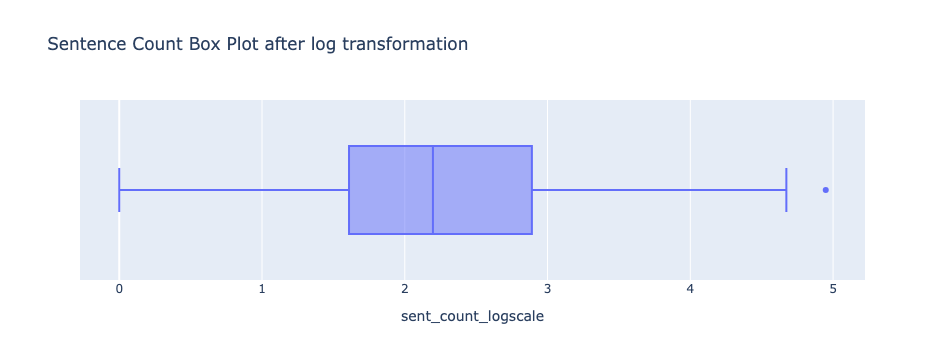

In [35]:
fig = px.box(df, x="sent_count_logscale", title="Sentence Count Box Plot after log transformation")
fig.show()

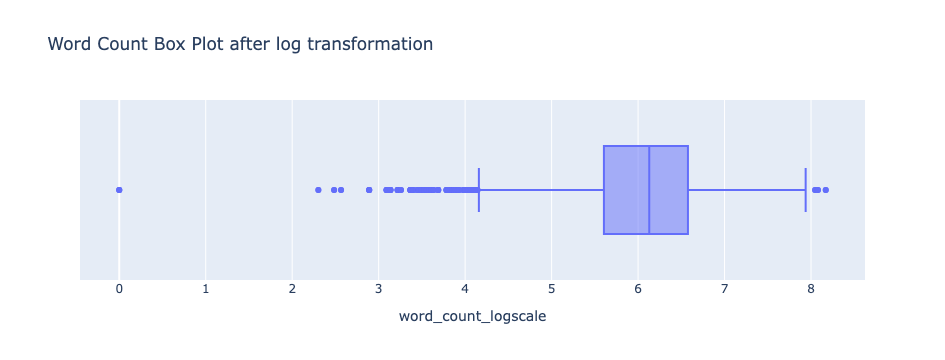

In [36]:
fig = px.box(df, x="word_count_logscale", title="Word Count Box Plot after log transformation")
fig.show()

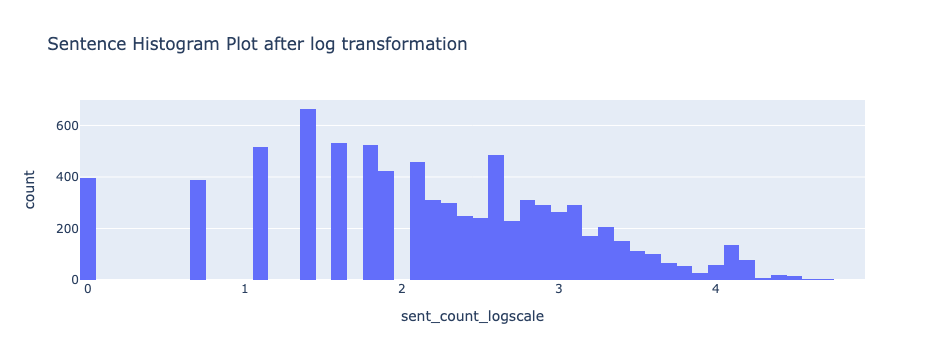

In [37]:
fig = px.histogram(df, x='sent_count_logscale',title="Sentence Histogram Plot after log transformation")
fig.show()

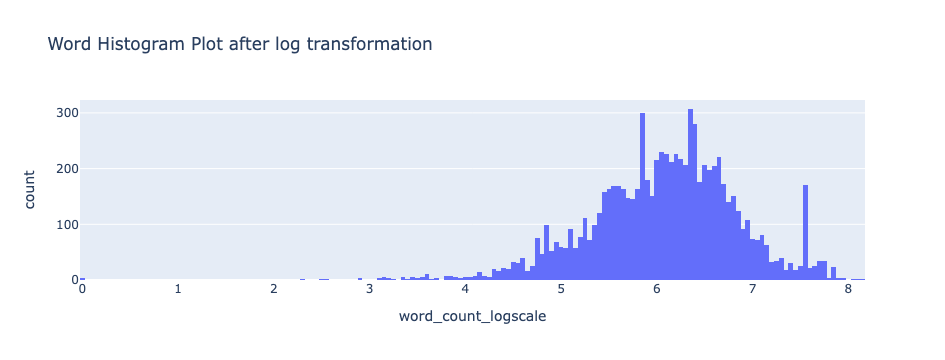

In [38]:
fig = px.histogram(df, x='word_count_logscale',title="Word Histogram Plot after log transformation")
fig.show()

In [39]:
df['sent_count_logscale'].skew().round(2)

-0.18

In [40]:
df['word_count_logscale'].skew().round(2)

-0.61

In [41]:
df = t_df

In [42]:
df.description.isnull().sum()

3

In [43]:
df.isnull().sum()

job id              0
job_title           3
company_name        3
company_location    3
posted_time         3
description         3
sent_count          0
word_count          0
dtype: int64

In [44]:
df.dropna(inplace=True)

In [45]:
df.shape

(7465, 8)

In [46]:
df.iloc[0].description

"Vice President of Customer SupportAs the Vice President of Customer Support, you'll lead a dynamic team dedicated to enhancing the customer experience, driving satisfaction, and fostering loyalty. Your strategic vision and operational prowess will be instrumental in shaping the support landscape to align with the company's overarching goals and objectives.Key Responsibilities:Leadership and Strategy:Develop and execute a comprehensive customer support strategy that aligns with the company mission.Define clear performance objectives and KPIs to drive team excellence.Provide strategic leadership, aligning team efforts with organizational values.Foster a customer-centric culture, emphasizing excellence in customer experiences.Team Management:Recruit, train, and manage a team of customer support professionals to ensure alignment with company objectives.Offer ongoing coaching, feedback, and performance evaluations to nurture team development.Establish robust communication frameworks to fos

In [47]:
df.sample(n=3, random_state=42)[['description']]

description
4736   Job Title: Financial Analysis & Controls 5 Job Type: Contract Site Type: Onsite (Redmond, WA) Duration: 9 Months 14 Days Job OverviewDo you have a passion for financial reporting? Are you looking for an opportunity to directly impact accounting and reporting at a Fortune 100 company? We have an exciting opportunity for a highly motivated, collaborative professional to join our External Reporting team. This position is part of the Corporate Accounting team that drives accounting and financial reporting excellence in the company. The Corporate Accounting team prepares, analyzes, and reviews our consolidated financial results and ensures compliance with US GAAP (GAAP) and Securities and Exchange Commission (SEC) reporting requirements. This External Reporting position plays a critical role in our financial reporting to shareholders and offers a unique enterprise-wide view of the company from the financial core. The position collaborates closely with a variety of stakeholders across the company, with direct visibility of senior leaders, and provides a great opportunity to grow and deliver impact. This position will report to the Senior Finance Director responsible for External Reporting in the company.Job ResponsibilitiesPlay a key role in the end-to-end process for periodic SEC filings, including 10-Qs and 10-Ks (and associated XBRL reporting efforts), to ensure that financial statements adhere to GAAP and SEC regulations Provide support to business partners, including Legal (CELA), Human Resources, and Investor Relations, to ensure the accuracy of other filings such as the Proxy Statement, benefit plan 11-Ks, earnings release 8-Ks, and foreign filings Partner with business groups, the Central Finance Team, and Investor Relations to understand key drivers of financial results and ensure accurate and consistent messaging across management reporting, earnings materials, and SEC filings Maintain knowledge of GAAP and SEC regulations, monitor changes to accounting and reporting guidance, assess the impact to the company, and make necessary changes to policies, controls, and disclosures as appropriate Understand internal accounting policies and maintain SOX compliance for certain controls over financial reporting Contribute toward improving effectiveness and efficiency in the corporate monthly/quarterly close and reporting process Other projects as designated Job RequirementsBS/BA degree in Finance or Accounting, or equivalent experience Minimum of 10 years of related work experience, preferably some public accounting; Additional years of experience preferred Accounting and/or financial reporting and analysis experience Knowledge of GAAP accounting and SEC reporting, including experience with technical research and implementation Experience with computer applications such as Microsoft Word, Excel, PowerPoint, and related financial software Experience with SEC-registered companies required Professional accounting certification, such as Certified Public Accountant (CPA) or equivalent Strong knowledge of GAAP accounting and SEC reporting, including experience with technical research and implementation Working knowledge of XBRL is a plus Strong project management skills including experience collaborating successfully across multiple teams and levels Excellent written and verbal communication skills with an ability to effectively communicate complex information, build trust, and influence key stakeholders Highly organized, able to manage multiple/competing activities under tight deadlines, prioritize for impact, and deliver results Must be flexible, adaptable, and detail-oriented
12893                                                                                                                                                                                                                                                                                                                                                      

First thing we noticed while looking at the job description scraped from Linkedin is that there are sentences which are not ended with a period "." and two sentences are joined.

For example: 
* "Position **OverviewJob Title**: **AnesthesiologistCertification**: MD"
* "**DescriptionSpecialization:AnesthesiologyAnesthesiology** CardiacJob Summary:"
* "401(k) match that increases with years of service and 100% Company paid occurrence-based malpractice **insuranceEmployee** stock purchase discount **planAbout** HCA Florida Bayonet Point Hospital:290-bed acute care facility is the only"

This could be a description provided on a new line were concatenated on a same line while scraping data. We'll fix this using a regex.


In [48]:
# function to add space between the words separated by newline but were joined while scraping 
def fix_new_line(desc): 
    return re.sub(r'\B(\w+)([A-Z]+[a-z]+)',r'\1 \2', desc)

In [49]:
# testing fix_new_line func
fix_new_line("Anesthesia physician employment in Tennessee : Inpatient Facility: Looking for an experienced Anesthesiologist in the Memphis, Tennessee area. Below you will find the Position Overview with all the detail regarding the position.Position OverviewJob Title: AnesthesiologistCertification: MD, DOSpecialty: AnesthesiologySetting: InpatientCredential Requirements: TN Medical License , DEA License, Board CertificationScheduling & LogisticsPT/FT: Full TimeOrder Type: Locum TenensShift: M-F + Weekend + Call; 8's 10's 12's and 24's available;Days Per Week: 5Hours per Week: 40Housing Notes: Flight, Hotel, Car Rental, MileageTransportation Notes: YesKPG Provider Services is a West Coast Focused Company with offices in Los Angeles and Las Vegas. We are focused on offering the best, most rewarding opportunities while providing excellent compensation and support. Outstanding service is at the core of our culture. Our Medical Professionals will experience a service relationship characterized by respect, a sense of urgency, and attention to detail.Our team offers benefits like geographic expertise, understanding commuting times, and top market compensation rates.In short, we focus intently on the things that matter to you with a commitment to achieve exceptional outcomes. Call us and experience the difference!For a complete listing of our current openings visit www.kpgproviders.com! Board Certified or Board Eligible Medical Doctor with or w/o US residency with current US work visa.")

"Anesthesia physician employment in Tennessee : Inpatient Facility: Looking for an experienced Anesthesiologist in the Memphis, Tennessee area. Below you will find the Position Overview with all the detail regarding the position.Position Overview Job Title: Anesthesiologist Certification: MD, DO Specialty: Anesthesiology Setting: Inpatient Credential Requirements: TN Medical License , DEA License, Board Certification Scheduling & LogisticsPT/FT: Full Time Order Type: Locum Tenens Shift: M-F + Weekend + Call; 8's 10's 12's and 24's available;Days Per Week: 5Hours per Week: 40 Housing Notes: Flight, Hotel, Car Rental, Mileage Transportation Notes: YesKPG Provider Services is a West Coast Focused Company with offices in Los Angeles and Las Vegas. We are focused on offering the best, most rewarding opportunities while providing excellent compensation and support. Outstanding service is at the core of our culture. Our Medical Professionals will experience a service relationship characterize

In [50]:
def remove_urls(desc): 
    return re.sub(r'(https:\/\/www\.|http:\/\/www\.|https:\/\/|http:\/\/)?[a-zA-Z]{2,}(\.[a-zA-Z]{2,})(\.[a-zA-Z]{2,})?\/[a-zA-Z0-9]{2,}|((https:\/\/www\.|http:\/\/www\.|https:\/\/|http:\/\/)?[a-zA-Z]{2,}(\.[a-zA-Z]{2,})(\.[a-zA-Z]{2,})?)|(https:\/\/www\.|http:\/\/www\.|https:\/\/|http:\/\/)?[a-zA-Z0-9]{2,}\.[a-zA-Z0-9]{2,}\.[a-zA-Z0-9]{2,}(\.[a-zA-Z0-9]{2,})?', ' ', desc)

In [51]:
remove_urls("Anesthesia physician employment in Tennessee : Inpatient Facility: Looking for an experienced Anesthesiologist in the Memphis, Tennessee area. Below you will find the Position Overview with all the detail regarding the position.Position Overview Job Title: Anesthesiologist Certification: MD, DO Specialty: Anesthesiology Setting: Inpatient Credential Requirements: TN Medical License , DEA License, Board Certification Scheduling & LogisticsPT/FT: Full Time Order Type: Locum Tenens Shift: M-F + Weekend + Call; 8's 10's 12's and 24's available;Days Per Week: 5Hours per Week: 40 Housing Notes: Flight, Hotel, Car Rental, Mileage Transportation Notes: YesKPG Provider Services is a West Coast Focused Company with offices in Los Angeles and Las Vegas. We are focused on offering the best, most rewarding opportunities while providing excellent compensation and support. Outstanding service is at the core of our culture. Our Medical Professionals will experience a service relationship characterized by respect, a sense of urgency, and attention to detail.Our team offers benefits like geographic expertise, understanding commuting times, and top market compensation rates.In short, we focus intently on the things that matter to you with a commitment to achieve exceptional outcomes. Call us and experience the difference!For a complete listing of our current openings visit www.kpgproviders.com! Board Certified or Board Eligible Medical Doctor with or w/o US residency with current US work visa.")

"Anesthesia physician employment in Tennessee : Inpatient Facility: Looking for an experienced Anesthesiologist in the Memphis, Tennessee area. Below you will find the Position Overview with all the detail regarding the   Overview Job Title: Anesthesiologist Certification: MD, DO Specialty: Anesthesiology Setting: Inpatient Credential Requirements: TN Medical License , DEA License, Board Certification Scheduling & LogisticsPT/FT: Full Time Order Type: Locum Tenens Shift: M-F + Weekend + Call; 8's 10's 12's and 24's available;Days Per Week: 5Hours per Week: 40 Housing Notes: Flight, Hotel, Car Rental, Mileage Transportation Notes: YesKPG Provider Services is a West Coast Focused Company with offices in Los Angeles and Las Vegas. We are focused on offering the best, most rewarding opportunities while providing excellent compensation and support. Outstanding service is at the core of our culture. Our Medical Professionals will experience a service relationship characterized by respect, a 

In [52]:
def remove_non_eng_chrs(text): 
    return re.sub('[^a-zA-Z]', ' ', text)

In [53]:
def remove_emails(text):
    return re.sub(r'\S*@\S*\s?', '', text)

In [54]:
def remove_multiple_spaces(desc): 
    return re.sub(r'\s+', ' ', desc)

In [55]:
def spell_len_fix(text): 
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

In [56]:
def convert_to_lowercase(text):
    return text.lower()

In [57]:
def remove_punctuation(text): 
    return text.translate(str.maketrans('','', string.punctuation))

In [58]:
def remove_non_ascii_chrs(text):
    return re.sub(r'[^\x00-\x7F]+', '', text)

In [59]:
def tokenize(text): 
    return word_tokenize(text)

In [60]:
def remove_whitespace(tokens): 
    return [t.strip() for t in tokens]

In [61]:
def remove_stop_words(tokens):
    return [t for t in tokens if t not in stopwords_eng]

In [62]:
def correct_spelling(tokens):
    return [spell(t) for t in tokens]

In [63]:
lem = WordNetLemmatizer()

def lemmatization(tokens):
    return [lem.lemmatize(t) for t in tokens]

In [64]:

def text_preprocess_pipeline(desc): 
    if not isinstance(desc, str):
        print(desc)
        return []
        
    text = fix_new_line(desc)
    text = remove_urls(text)
    text = remove_emails(text)
    text = remove_non_eng_chrs(text)
    text = remove_multiple_spaces(text)
    text = remove_non_ascii_chrs(text)
    text = spell_len_fix(text)
    text = remove_punctuation(text)
    text = convert_to_lowercase(text)
    tokens = tokenize(text)
    tokens = remove_stop_words(tokens)
    tokens = remove_whitespace(tokens)
    # tokens = correct_spelling(tokens)
    return lemmatization(tokens)    
 

In [65]:
tqdm.pandas(desc="Pre-Processing Description")
df['preprocessed_description'] = df.description.progress_apply(text_preprocess_pipeline)

Pre-Processing Description: 100%|██████████| 7465/7465 [00:49<00:00, 152.24it/s]


In [66]:
df.head()

job id                           job_title           company_name  \
0  3856120323  Vice President of Customer Support     Motion Recruitment   
1  3852723097        Sr. Customer Success Manager         Social Benefit   
2  3855972061      Night Warehouse Order Selector  Direct Employers Jobs   
3  3856133377       Marketing/Social Media Intern                    FTC   
4  3856133739                     Product Manager                Oddball   

  company_location     posted_time  \
0      Atlanta, GA      1 hour ago   
1  Los Angeles, CA  28 minutes ago   
2  Kailua-Kona, HI     2 hours ago   
3     New York, NY      1 hour ago   
4    United States  50 minutes ago   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [70]:
df['clean_description'] = df.preprocessed_description.apply(lambda x: ' '.join(x))

In [71]:
df.head()

job id                           job_title           company_name  \
0  3856120323  Vice President of Customer Support     Motion Recruitment   
1  3852723097        Sr. Customer Success Manager         Social Benefit   
2  3855972061      Night Warehouse Order Selector  Direct Employers Jobs   
3  3856133377       Marketing/Social Media Intern                    FTC   
4  3856133739                     Product Manager                Oddball   

  company_location     posted_time  \
0      Atlanta, GA      1 hour ago   
1  Los Angeles, CA  28 minutes ago   
2  Kailua-Kona, HI     2 hours ago   
3     New York, NY      1 hour ago   
4    United States  50 minutes ago   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [89]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_description'])

In [90]:
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_word_freq = dict(zip(feature_names, tfidf_matrix.toarray().sum(axis=0)))

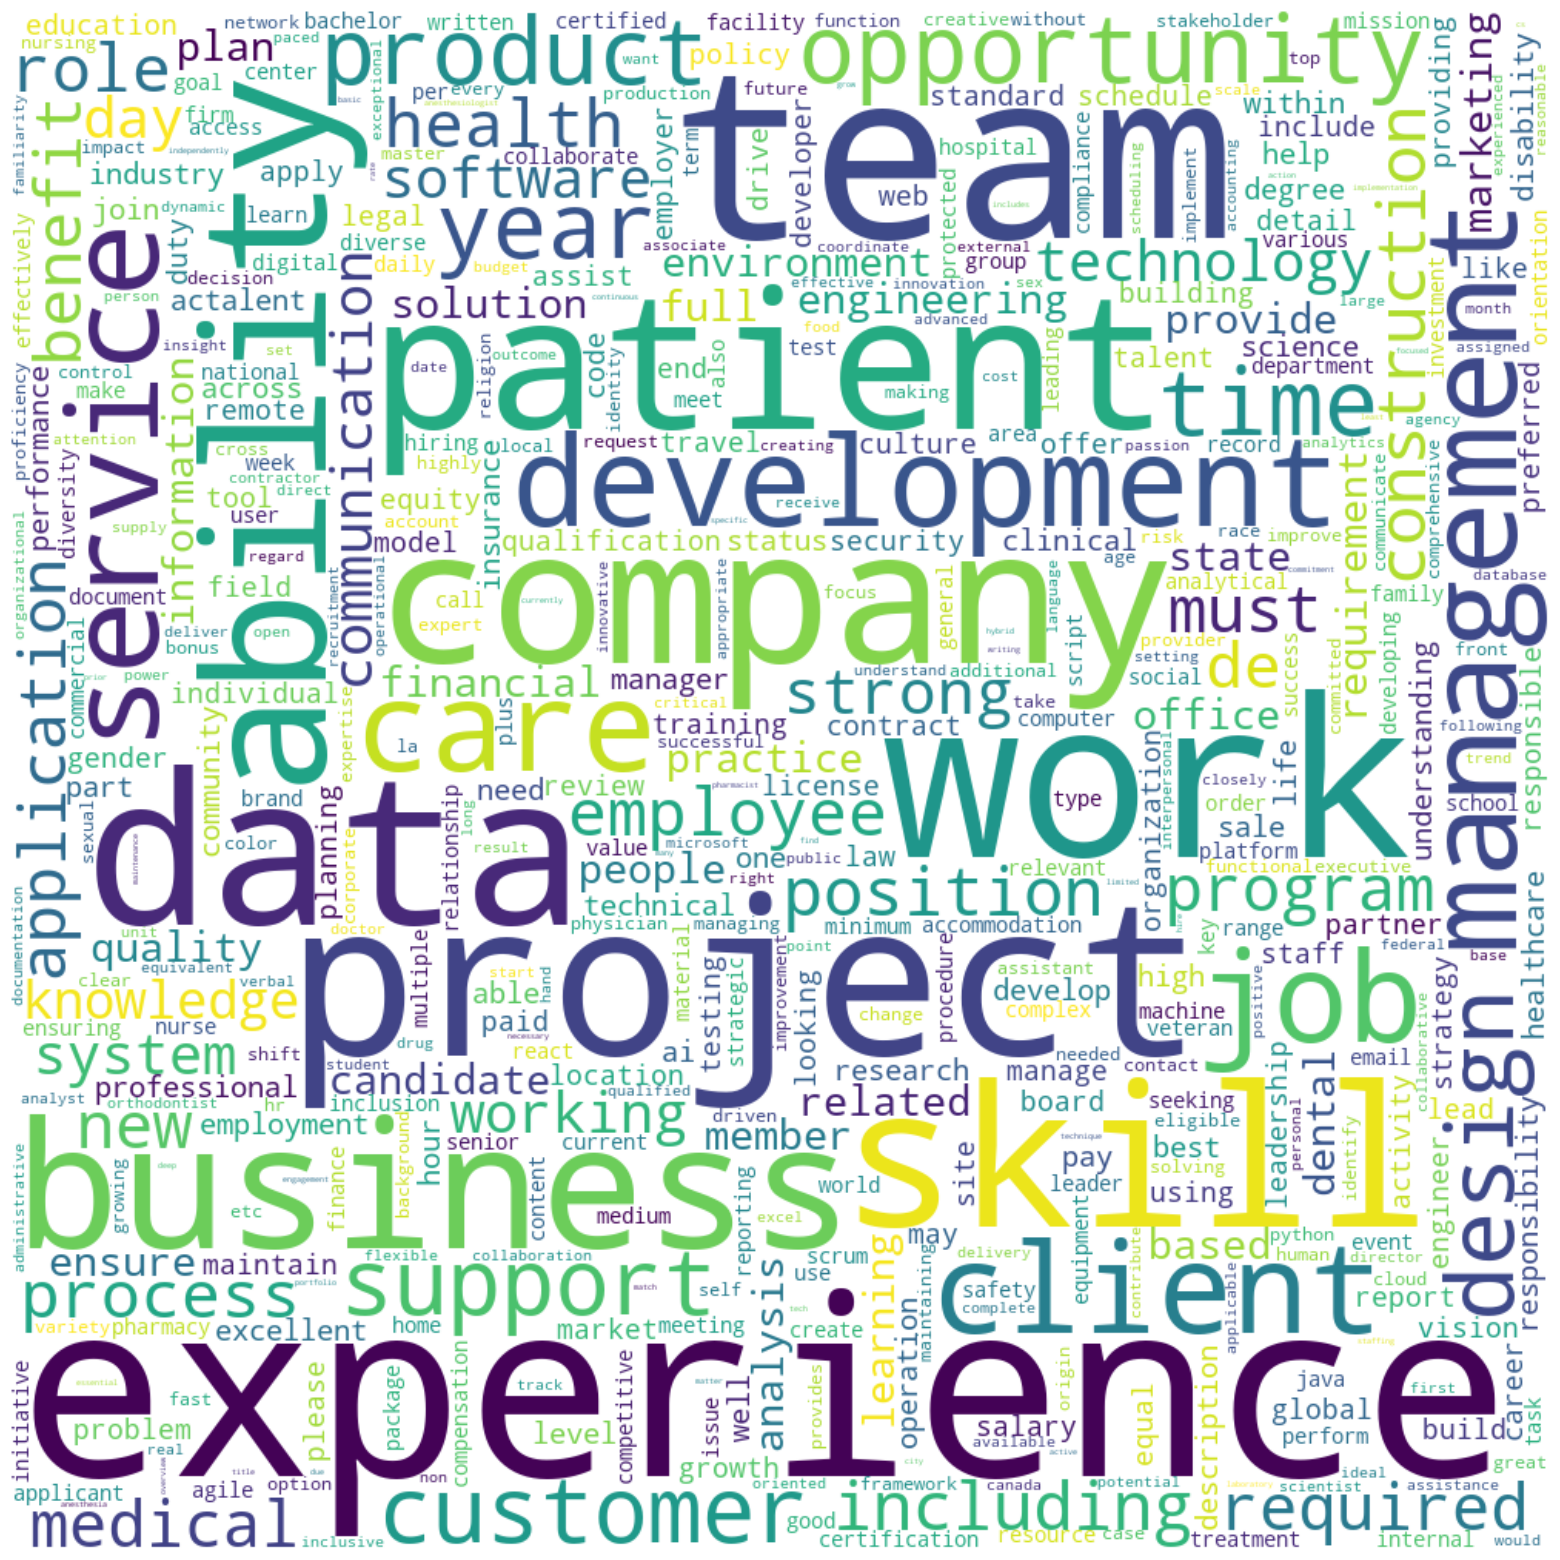

In [91]:
plt.figure(figsize = (20,20))

wordcloud = WordCloud(max_words = 500 , width = 1000 , height = 1000 , background_color="white").generate_from_frequencies(tfidf_word_freq)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [107]:
wcss = []

for i in tqdm(range(1, 500, 20)):
    clustering = KMeans(n_clusters=i, init='k-means++', random_state=42)
    clustering.fit(tfidf_matrix)
    wcss.append(clustering.inertia_)

  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

100%|██████████| 25/25 [57:03<00:00, 136.96s/it]


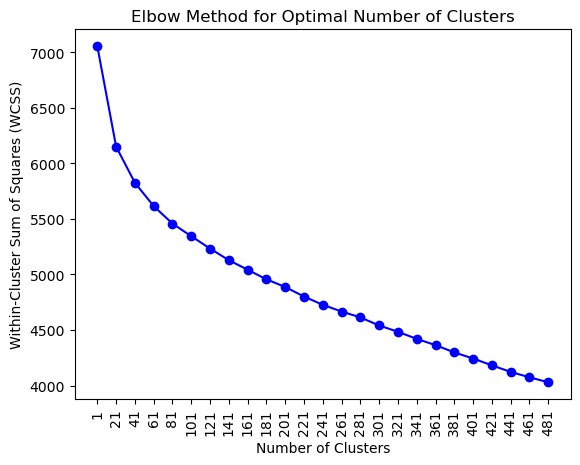

In [112]:
plt.plot(range(1, 500, 20), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 500, 20))
plt.xticks(rotation=90)
plt.show()

In [ ]:
wcss = []

for i in tqdm(range(1, 2000, 100)):
    clustering = KMeans(n_clusters=i, init='k-means++', random_state=42)
    clustering.fit(tfidf_matrix)
    wcss.append(clustering.inertia_)

In [97]:
label_encoder = LabelEncoder()
df['job_title_encoded'] = label_encoder.fit_transform(df['job_title'])

In [106]:
reshape_job_title_enc = df['job_title_encoded']

In [100]:
tfidf_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
combined_matrix = np.hstack((tfidf_matrix.toarray(), nominal_data_encoded.reshape(-1, 1)))